
# Deep Learning Portfolio Strategy via Sharpe Ratio Optimization

Проект демонстрирует обучение нейросети, которая предсказывает портфельные веса, 
оптимизируя напрямую коэффициент Шарпа.

## Особенности:
- Time-series split без утечки данных
- Оптимизация Sharpe Ratio как функции потерь
- Сравнение с:
  - Equal weight baseline
  - Momentum strategy
  - Linear model
  - Deep neural net


In [ ]:
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim


from typing import Tuple
import matplotlib.pyplot as plt

## Data
Данные не загружены в репозиторий. Ожидается файл:

close.parquet — дневные цены активов (Date index, columns = tickers)

Ноутбук показывает архитектуру, обучение и логику построения стратегии.


In [ ]:
try:
    start_df = pd.read_parquet('close.parquet')
except FileNotFoundError:
    raise FileNotFoundError("Add close.parquet to run this notebook.")


In [ ]:
start_df_clean = start_df.dropna(axis=1)
start_df_clean.shape
start_df_clean

,A,AACG,AAMI,AAOI,AAPL,AAT,ABBV,ABCB,ABEV,ABG,...,YDKG,YELP,YPF,ZBRA,ZEUS,ZG,ZTR,ZTS,ZUMZ,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,37.636368,0.610933,13.572110,16.290001,23.776182,25.803417,38.010921,28.721344,2.925977,66.519997,...,111.400002,27.600000,15.378125,66.489998,10.857997,24.510000,3.647442,43.853802,15.160000,8.385332
2016-01-05,37.506878,0.626278,13.691565,16.080000,23.180365,26.606346,37.852570,28.836063,2.967090,65.129997,...,111.199997,26.620001,15.309993,64.820000,10.793200,24.040001,3.650455,44.540329,15.310000,8.110702
2016-01-06,37.673359,0.689578,13.204547,16.049999,22.726725,26.578897,37.859173,28.359577,2.932829,57.340000,...,111.599998,25.910000,14.580019,62.230000,10.793200,23.879999,3.617325,44.549610,15.080000,7.781149
2016-01-07,36.073189,0.609015,12.497002,15.290000,21.767565,26.009302,37.747002,27.830154,2.816338,55.619999,...,110.400002,25.270000,14.346428,59.410000,10.173012,23.020000,3.575158,43.195118,16.809999,7.414975
2016-01-08,35.693962,0.565856,12.552132,14.790000,21.882662,25.775970,36.717712,27.556606,2.864304,53.340000,...,110.400002,25.049999,14.258830,59.250000,9.839771,23.889999,3.566123,42.564262,16.620001,7.181542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,154.316727,1.180000,25.851524,5.590000,176.796082,29.805992,115.908318,47.185169,2.272167,167.490005,...,7.800000,37.209999,4.070000,606.330017,21.783871,60.990002,5.924202,237.800217,47.770000,35.209629
2021-12-28,154.744476,1.170000,25.623016,5.480000,175.776443,29.684269,115.891083,47.488670,2.263875,169.520004,...,6.640000,36.900002,4.070000,597.320007,21.641058,60.000000,5.924202,235.620087,47.570000,35.393059
2021-12-29,156.173523,1.060000,25.473984,5.300000,175.864685,29.830334,116.727570,47.659389,2.247290,169.000000,...,6.200000,36.509998,3.990000,601.119995,22.079018,59.209999,5.942968,238.301834,48.130001,35.460644


In [ ]:
returns = np.log(start_df_clean / start_df_clean.shift(1)).dropna()
returns

,A,AACG,AAMI,AAOI,AAPL,AAT,ABBV,ABCB,ABEV,ABG,...,YDKG,YELP,YPF,ZBRA,ZEUS,ZG,ZTR,ZTS,ZUMZ,ZWS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.003446,0.024807,0.008763,-0.012975,-0.025379,0.030643,-0.004175,0.003986,0.013954,-0.021117,...,-0.001797,-0.036153,-0.004440,-0.025437,-0.005986,-0.019362,0.000826,0.015534,0.009846,-0.033300
2016-01-06,0.004429,0.096284,-0.036219,-0.001867,-0.019764,-0.001032,0.000174,-0.016662,-0.011614,-0.127387,...,0.003591,-0.027034,-0.048854,-0.040777,0.000000,-0.006678,-0.009117,0.000208,-0.015137,-0.041480
2016-01-07,-0.043403,-0.124236,-0.055072,-0.048510,-0.043121,-0.021663,-0.002967,-0.018845,-0.040530,-0.030456,...,-0.010811,-0.025011,-0.016151,-0.046375,-0.059178,-0.036678,-0.011725,-0.030876,0.108605,-0.048203
2016-01-08,-0.010568,-0.073503,0.004402,-0.033248,0.005274,-0.009012,-0.027647,-0.009878,0.016888,-0.041856,...,0.000000,-0.008744,-0.006125,-0.002697,-0.033306,0.037097,-0.002531,-0.014712,-0.011367,-0.031987
2016-01-11,-0.016987,-0.155564,0.007294,-0.005424,0.016062,0.006634,-0.032323,-0.000961,-0.016888,0.043473,...,-0.012762,-0.029986,-0.028385,-0.006604,-0.093618,-0.005456,-0.011895,-0.028744,0.027887,-0.002553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.005939,-0.049597,0.013932,-0.008905,0.022715,0.010125,0.009869,0.010914,0.000000,0.018500,...,0.131336,0.002152,0.037551,0.040250,0.011871,-0.021893,0.001057,0.016360,0.039933,0.011029
2021-12-28,0.002768,-0.008511,-0.008879,-0.019874,-0.005784,-0.004092,-0.000149,0.006412,-0.003656,0.012047,...,-0.161012,-0.008366,0.000000,-0.014971,-0.006577,-0.016365,0.000000,-0.009210,-0.004196,0.005196
2021-12-29,0.009192,-0.098735,-0.005833,-0.033398,0.000502,0.004909,0.007192,0.003588,-0.007353,-0.003072,...,-0.068563,-0.010625,-0.019852,0.006342,0.020035,-0.013254,0.003163,0.011317,0.011703,0.001908


In [ ]:
LOOKBACK = 30
def make_dataset(returns: pd.DataFrame, lookback: int):
    X, y, dates = [], [], []
    values = returns.values
    for t in range(lookback, len(returns)):
        X.append(values[t-lookback:t])
        y.append(values[t])
        dates.append(returns.index[t])
    return np.array(X), np.array(y), dates


X, y, dates = make_dataset(returns, LOOKBACK)
print(X.shape, y.shape)

(1480, 30, 1291) (1480, 1291)


In [ ]:
split_date = pd.Timestamp('2020-01-01')


train_idx = [i for i, d in enumerate(dates) if d < split_date]
test_idx = [i for i, d in enumerate(dates) if d >= split_date]


X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]


print(X_train.shape, X_test.shape)

(975, 30, 1291) (505, 30, 1291)


In [ ]:
def equal_weight_portfolio(returns: np.ndarray):
    w = np.ones(returns.shape[1])
    mask = ~np.isnan(returns)

    w = w / mask.sum(axis=1, keepdims=True)

    pnl = np.nansum(returns * w, axis=1)
    return pnl


In [ ]:
naive_pnl = equal_weight_portfolio(y_test)

sharpe_naive = (
    np.nanmean(naive_pnl) /
    np.nanstd(naive_pnl) *
    np.sqrt(252)
)

sharpe_naive


np.float64(0.40140801041923085)

In [ ]:
class LinearMLP(nn.Module):
    def __init__(self, lookback, n_assets):
        super().__init__()
        self.model = nn.Linear(lookback * n_assets, n_assets)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [ ]:
def sharpe_loss(pnl: torch.Tensor, eps: float = 1e-6):
    mean = pnl.mean()
    std = pnl.std()
    sharpe = mean / (std + eps)
    return -sharpe

In [ ]:
def train_model(model, X, y, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    y_t = torch.tensor(y, dtype=torch.float32, device=device)
    


    for epoch in range(epochs):
        optimizer.zero_grad()
        weights = model(X_t)
        pnl = (weights * y_t).sum(dim=1)
        loss = sharpe_loss(pnl)
        loss.backward()
        optimizer.step()


    return model
n_assets = y_train.shape[1]


linear_model = LinearMLP(LOOKBACK, n_assets)
linear_model = train_model(linear_model, X_train, y_train)

In [ ]:
with torch.no_grad():
    w_test = linear_model(torch.tensor(X_test, dtype=torch.float32))
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    mask = torch.isfinite(y_test_t)

    y_test_t = torch.nan_to_num(y_test_t, nan=0.0)

    w_test = w_test * mask
    w_test = w_test / (w_test.abs().sum(dim=1, keepdim=True) + 1e-8)

    pnl_linear = (w_test * y_test_t).sum(dim=1).cpu().numpy()

sharpe_linear = (
    np.mean(pnl_linear) /
    (np.std(pnl_linear) + 1e-8) *
    np.sqrt(252)
)

sharpe_linear



np.float64(0.5925134989816072)

In [ ]:
class SharpeNet(nn.Module):
    def __init__(self, lookback, n_assets, hidden=256, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(lookback * n_assets, hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden, n_assets)
        )


    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [ ]:
sharpe_model = SharpeNet(LOOKBACK, n_assets, hidden=512, dropout=0.1)
sharpe_model = train_model(sharpe_model, X_train, y_train, epochs=20, lr=1e-3)

In [ ]:
with torch.no_grad():
    w_test = sharpe_model(torch.tensor(X_test, dtype=torch.float32))
    pnl_net = (w_test * torch.tensor(y_test, dtype=torch.float32)).sum(dim=1).numpy()


sharpe_nn = pnl_net.mean() / pnl_net.std() * np.sqrt(252)
sharpe_nn

np.float64(0.8538982833420016)

In [ ]:

close_full = pd.read_parquet('close.parquet')

close_clean = close_full[start_df_clean.columns]

assert close_clean.index.equals(start_df_clean.index),

lookback_start = 7  # d-7
lookback_end = 1    # d-1

price_d_minus_7 = close_clean.shift(7)
price_d_minus_1 = close_clean.shift(1)

alpha_ratio = price_d_minus_7 / price_d_minus_1

def momentum_portfolio_weights(alpha_df: pd.DataFrame) -> pd.DataFrame:
    
    alpha_clean = alpha_df.fillna(0.0)

    abs_sum = alpha_clean.abs().sum(axis=1)
    abs_sum = abs_sum.replace(0, 1.0)

    weights = alpha_clean.div(abs_sum, axis=0)
    return weights

weights_momentum = momentum_portfolio_weights(alpha_ratio)

returns_full = np.log(close_clean / close_clean.shift(1))

common_dates = weights_momentum.index.intersection(returns_full.index)
weights_aligned = weights_momentum.loc[common_dates]
returns_aligned = returns_full.loc[common_dates]

pnl_momentum = (weights_aligned * returns_aligned).sum(axis=1)
pnl_momentum = pnl_momentum.dropna().values  # → numpy array

test_start = pd.Timestamp('2020-01-01')
pnl_momentum_test = pnl_momentum[common_dates >= test_start]

min_len_test = min(len(pnl_momentum_test), len(naive_pnl), len(pnl_linear), len(pnl_sharpe))
pnl_momentum_test = pnl_momentum_test[:min_len_test]

if len(pnl_momentum_test) > 1 and np.std(pnl_momentum_test) > 1e-10:
    sharpe_momentum = (
        np.mean(pnl_momentum_test) /
        np.std(pnl_momentum_test) *
        np.sqrt(252)
    )
else:
    sharpe_momentum = np.nan

print(f"✅ Momentum baseline (close[d−7]/close[d−1]):")
print(f"   Длина тестового периода: {len(pnl_momentum_test)} дней")
print(f"   Средняя дневная доходность: {np.mean(pnl_momentum_test)*100:.4f}%")
print(f"   Годовой коэффициент Шарпа: {sharpe_momentum:.3f}")

momentum_pnl = pnl_momentum_test

✅ Momentum baseline (close[d−7]/close[d−1]):
   Длина тестового периода: 505 дней
   Средняя дневная доходность: 0.0619%
   Годовой коэффициент Шарпа: 0.503


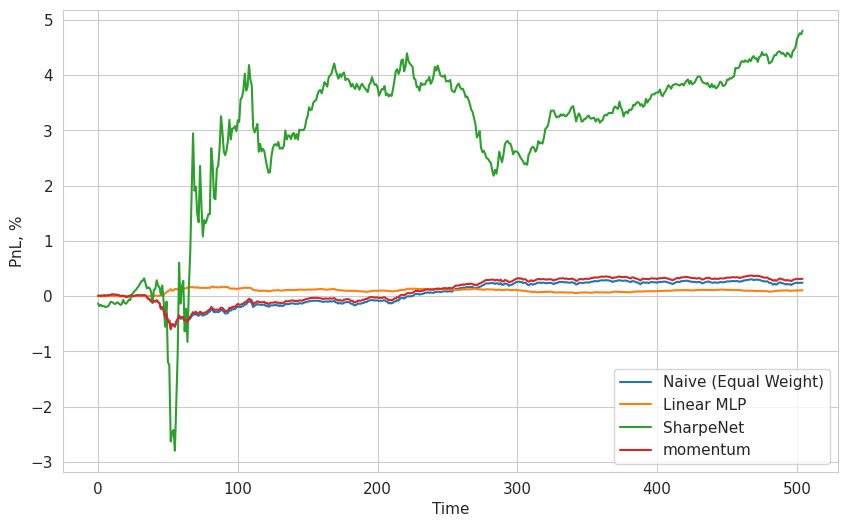

In [ ]:

cum_naive = np.cumsum(naive_pnl)
cum_linear = np.cumsum(pnl_linear)
cum_nn = np.cumsum(pnl_net)
cum_momentum = np.cumsum(momentum_pnl)

plt.figure(figsize=(10, 6))
plt.plot(cum_naive, label='Naive (Equal Weight)')
plt.plot(cum_linear, label='Linear MLP')
plt.plot(cum_nn, label='SharpeNet')
plt.plot(cum_momentum, label='momentum')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PnL, %')
plt.grid(True)
plt.show()

In [ ]:
from tabulate import tabulate
import numpy as np

naive_pnl1 = naive_pnl[:252]
naive_pnl2 = naive_pnl[252:]
pnl_linear1 = pnl_linear[:252]
pnl_linear2 = pnl_linear[252:]
pnl_net1 = pnl_net[:252]
pnl_net2 = pnl_net[252:]

def sharpe_ratio(pnl: np.ndarray, annualization_factor: float = 252) -> float:
    if len(pnl) == 0:
        return np.nan
    mean_pnl = np.mean(pnl)
    std_pnl = np.std(pnl, ddof=1)
    if std_pnl == 0:
        return np.inf if mean_pnl > 0 else -np.inf if mean_pnl < 0 else 0.0
    return (mean_pnl / std_pnl) * np.sqrt(annualization_factor)

data = [
    ["Naive",
     f"{sharpe_ratio(naive_pnl1):.3f}",
     f"{sharpe_ratio(naive_pnl2):.3f}",
     f"{sharpe_ratio(naive_pnl):.3f}"],
    ["Linear",
     f"{sharpe_ratio(pnl_linear1):.3f}",
     f"{sharpe_ratio(pnl_linear2):.3f}",
     f"{sharpe_ratio(pnl_linear):.3f}"],
    ["Neural Net",
     f"{sharpe_ratio(pnl_net1):.3f}",
     f"{sharpe_ratio(pnl_net2):.3f}",
     f"{sharpe_ratio(pnl_net):.3f}"],
]

# Вывод
print(tabulate(data,
               headers=["Модель", "2021 (год)", "2022 (год)", "Весь период"],
               tablefmt="github",
               numalign="right"))

| Модель     |   2021 (год) |   2022 (год) |   Весь период |
|------------|--------------|--------------|---------------|
| Naive      |        0.223 |        0.944 |         0.401 |
| Linear     |        1.169 |       -0.343 |          0.64 |
| Neural Net |        0.807 |        0.864 |         0.688 |
